# IMPORT LIBRARIES AND DATASET

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree

import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:

# Update the file path to the correct location of your Excel file
path = '/content/PublicLEEDProjectsDirectory.xlsx'

# Read the Excel file using pandas
dataset = pd.read_excel(path, engine="openpyxl")


#EXPLORATORY DATA ANALYSIS

In [3]:
display(dataset.head())
print(dataset.shape)
print(list(dataset.columns))

,ID,Isconfidential,ProjectName,Street,City,State,Zipcode,Country,LEEDSystemVersionDisplayName,PointsAchieved,CertLevel,CertDate,IsCertified,OwnerTypes,GrossFloorArea,UnitOfMeasurement,TotalPropArea,ProjectTypes,OwnerOrganization,RegistrationDate
0,10000000,No,PNC Firstside Center,500 First Avenue,Pittsburgh,PA,15219,US,LEED-NC 2.0,33,Silver,2000-10-01 00:00:00,Yes,Profit Org.,647000.0,Sq ft,202923.0,Commercial Office,L.D. Astorino Companies,2000-03-31 00:00:00
1,10000001,Yes,Confidential,Confidential,Confidential,IN,Confidential,US,LEED-NC 2.0,NaN,NaN,NaN,No,Confidential,291000.0,Sq ft,130637.0,Confidential,Confidential,2000-06-01 00:00:00
2,10000002,No,Bethel Commercial Center,53 W. Jackson,Chicago,IL,60604,US,LEED-NC 2.0,45,Gold,2007-11-05 00:00:00,Yes,Non-Profit Org.,22592.0,Sq ft,27500.0,"Commercial Office, Restaurant, Retail, Daycare...",Bethel New Life,2001-08-01 00:00:00
3,10000003,Yes,Confidential,Confidential,Confidential,NY,Confidential,US,LEED-NC 2.1,NaN,NaN,NaN,No,Confidential,190000.0,Sq ft,NaN,Confidential,Confidential,2006-09-19 00:00:00
4,10000004,No,The Chicago Center for Green Technology,445 N. Sacramento Avenue,Chicago,IL,60612,US,LEED-NC 1.0 Pilot,38,Platinum,2003-06-17 00:00:00,Yes,Local Government,28356.0,Sq ft,28356.0,"Industrial, Commercial Office",City of Chicago Department of the Enviro,2000-06-01 00:00:00


(178844, 20)
['ID', 'Isconfidential', 'ProjectName', 'Street', 'City', 'State', 'Zipcode', 'Country', 'LEEDSystemVersionDisplayName', 'PointsAchieved', 'CertLevel', 'CertDate', 'IsCertified', 'OwnerTypes', 'GrossFloorArea', 'UnitOfMeasurement', 'TotalPropArea', 'ProjectTypes', 'OwnerOrganization', 'RegistrationDate']


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178844 entries, 0 to 178843
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ID                            178844 non-null  int64  
 1   Isconfidential                178844 non-null  object 
 2   ProjectName                   178842 non-null  object 
 3   Street                        178821 non-null  object 
 4   City                          178844 non-null  object 
 5   State                         178833 non-null  object 
 6   Zipcode                       178768 non-null  object 
 7   Country                       178843 non-null  object 
 8   LEEDSystemVersionDisplayName  178844 non-null  object 
 9   PointsAchieved                108875 non-null  object 
 10  CertLevel                     101031 non-null  object 
 11  CertDate                      101043 non-null  object 
 12  IsCertified                   178844 non-nul

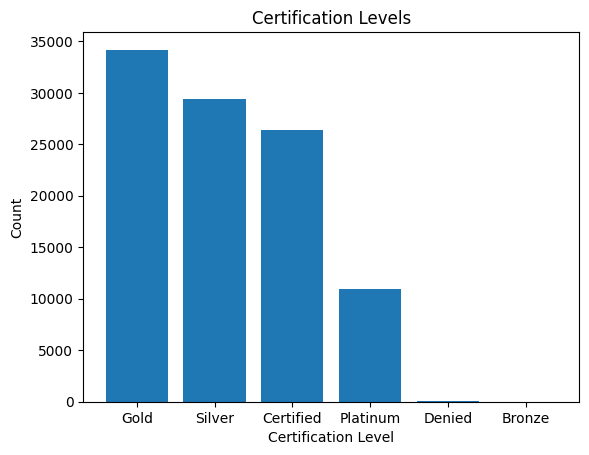

In [5]:


# count the unique values of CertLevel
cert_levels = dataset['CertLevel'].value_counts()

# create a bar chart
plt.bar(cert_levels.index, cert_levels.values)

# set the chart title and axis labels
plt.title('Certification Levels')
plt.xlabel('Certification Level')
plt.ylabel('Count')

# display the chart
plt.show()

#Data Cleaning and Transformation

In [7]:
# Apply the data filtering logic
df = dataset[~((dataset['IsCertified'] == 'No') | (dataset['Country'] != 'US')| (dataset['CertLevel'] == 'Bronze')| (dataset['CertLevel'] == 'Denied'))]
df = df.drop('TotalPropArea', axis=1)
df = df.dropna(subset=['ProjectTypes'])
df['OwnerTypes'].fillna(value='Others', inplace=True)

# replace OwnerTypes
df['OwnerTypes'] = df['OwnerTypes'].replace(to_replace={
    r'(?i).*Investor.*': 'Investor',
    r'(?i).*Educational.*': 'Educational',
    r'(?i).*Government.*': 'Government Use',
    r'(?i).*Community.*': 'Community Development Corporation',
    r'(?i).*Corporate.*': 'Corporate',
    r'(?i).*(Profit|Confidential|Other|Individual|Business Improvement District|Main Street Organization).*': 'Others'
}, regex=True)

# replace ProjectTypes
df['ProjectTypes'] = df['ProjectTypes'].replace(to_replace={
    r'(?i).*Office.*': 'Office',
    r'(?i).*Retail.*': 'Retail',
    r'(?i).*Core.*': 'Core learning',
    r'(?i).*Assembly.*': 'Public Assembly',
    r'(?i).*(Lodging|Home).*': 'Lodging',
    r'(?i).*Restaurant.*': 'Service',
    r'(?i).*Service.*': 'Service',
    r'(?i).*Recreation.*': 'Service',
    r'(?i).*(Care|Daycare|Healthcare).*': 'Health Care',
    r'(?i).*Warehouse.*': 'Warehouse and distribution centre',
    r'(?i).*Industrial.*': 'Industrial Manufacturing',
    r'(?i).*Multi-Unit Residence.*': 'Multi-Unit Residence',
    r'(?i).*Public.*': 'Public Order and Safety',
    r'(?i).*(Residential|family|MF).*': 'Multi-Unit Residence',
    r'(?i).*Education.*': 'Education',
    r'(?i).*(School|Campus).*': 'Education',
    r'(?i).*Military.*': 'Military Base',
    r'(?i).*(Airport|ND|Other|Laboratory|Community|Interpretive|Confidential|Transportation|Financial|Special|Datacenter|Park|Transit|Library|HOtel|stadium).*': 'Others'
}, regex=True)

# selecting columns for model building
selected_columns = ['GrossFloorArea', 'State','OwnerTypes','ProjectTypes','LEEDSystemVersionDisplayName','CertLevel']
df = df[selected_columns]

# Drop rows with NaN values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)


# Replace 0 with 'Others' in 'ProjectTypes' column
df['ProjectTypes'] = df['ProjectTypes'].replace('0', 'Others')
df['ProjectTypes'] = df['ProjectTypes'].replace('USA', 'Others')


# Convert float columns to string
df['State'] = df['State'].astype(str)
df['OwnerTypes'] = df['OwnerTypes'].astype(str)
df['ProjectTypes'] = df['ProjectTypes'].astype(str)
# df['LEEDSystemVersionDisplayName'] = df['LEEDSystemVersionDisplayName'].astype(str)
df['CertLevel'] = df['CertLevel'].astype(str)





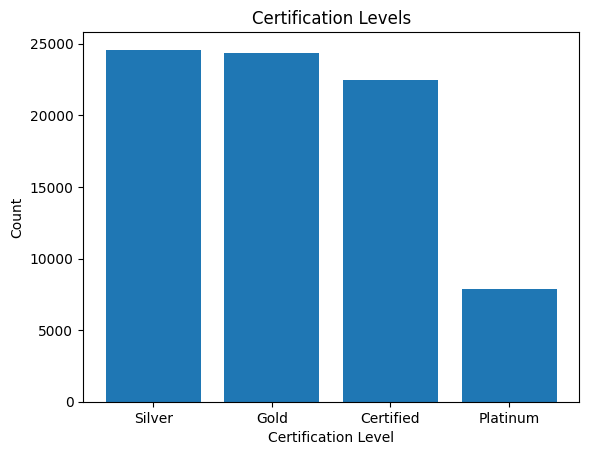

In [8]:


# count the unique values of CertLevel
cert_levels = df['CertLevel'].value_counts()

# create a bar chart
plt.bar(cert_levels.index, cert_levels.values)

# set the chart title and axis labels
plt.title('Certification Levels')
plt.xlabel('Certification Level')
plt.ylabel('Count')

# display the chart
plt.show()

###VISUALIZATIONS

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79288 entries, 0 to 79287
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   GrossFloorArea                79288 non-null  float64
 1   State                         79288 non-null  object 
 2   OwnerTypes                    79288 non-null  object 
 3   ProjectTypes                  79288 non-null  object 
 4   LEEDSystemVersionDisplayName  79288 non-null  object 
 5   CertLevel                     79288 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.6+ MB


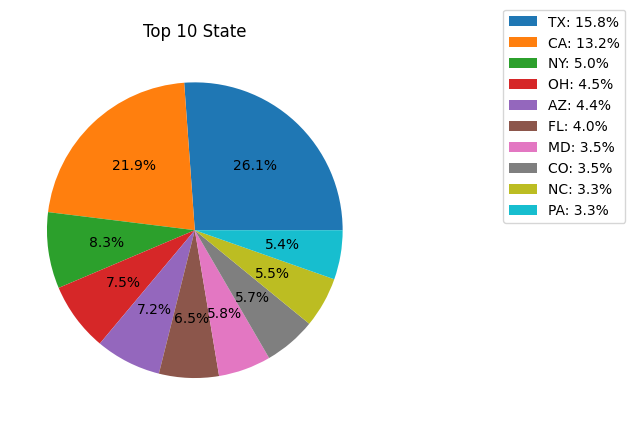

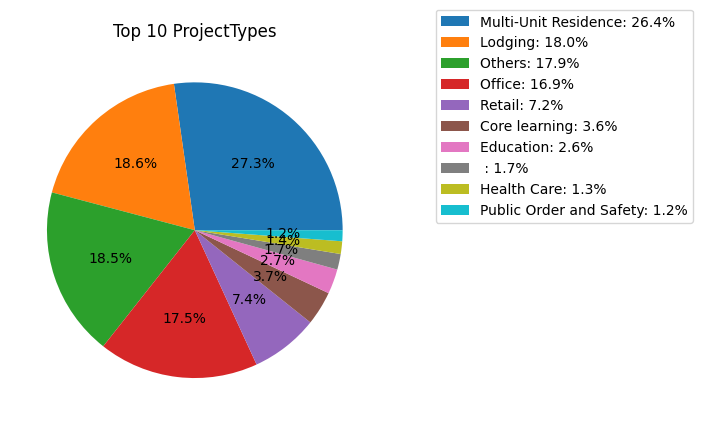

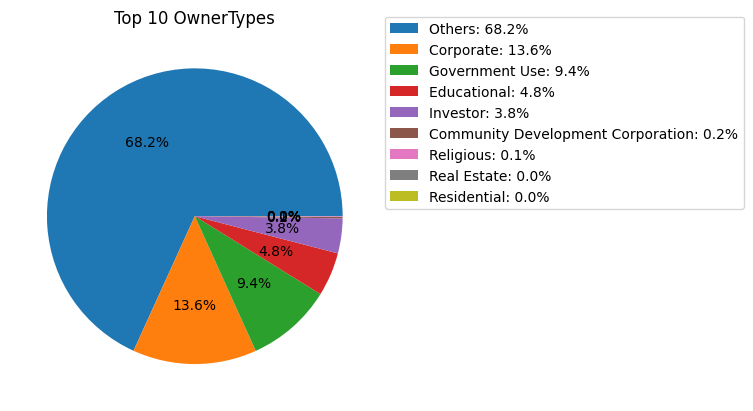

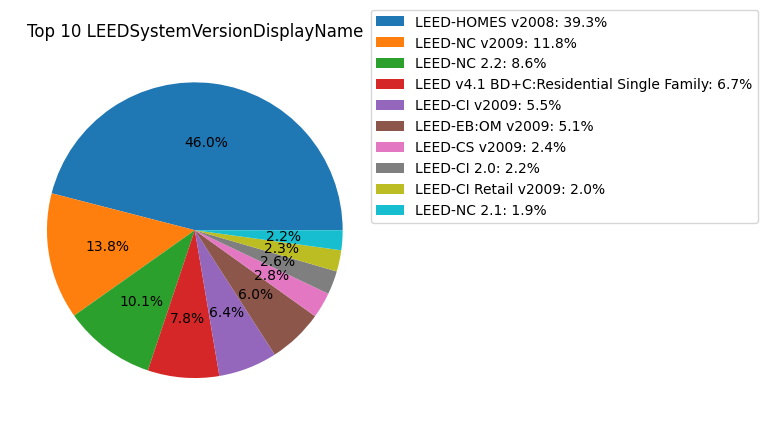

In [10]:


# list of column names to plot
columns_to_plot = ['State', 'ProjectTypes', 'OwnerTypes', 'LEEDSystemVersionDisplayName']

# plot a pie chart for each column
for col in columns_to_plot:
    # count occurrences of each unique value
    counts = df[col].value_counts().head(10)
    # calculate percentage of total count for each value
    percentages = counts / len(df) * 100
    # plot the pie chart
    plt.figure()
    plt.pie(counts, labels=None, autopct='%1.1f%%')
    plt.title(f'Top 10 {col}')
    plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))


    # create a legend with the percentage values
    legend_labels = [f'{label}: {percentages[label]:.1f}%' for label in counts.index]
    plt.legend(legend_labels, loc='lower center', bbox_to_anchor=(1.5, 0.5))
    
    plt.show()





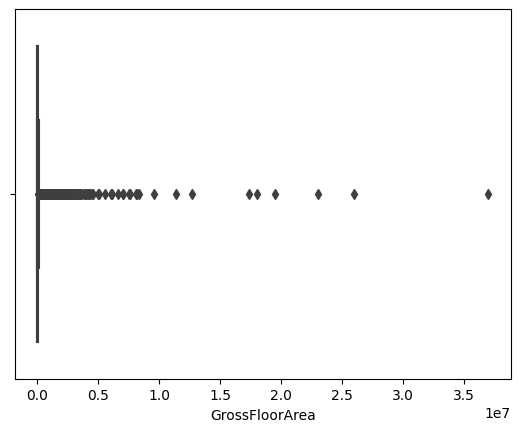

In [11]:
#Checking for outliers in the countinuous data

sns.boxplot(x = df['GrossFloorArea'])
plt.show()

In [12]:
# Get unique values and their frequencies
value_counts = df['LEEDSystemVersionDisplayName'].value_counts()

# Sort the values by frequency
sorted_values = value_counts.sort_values(ascending=False)

# Calculate percentage of unique values
total_count = sorted_values.sum()
percentage_values = (sorted_values / total_count) * 100

# Create a new dataframe with count and percentage values
result_df = pd.DataFrame({'Value': sorted_values.index, 'Count': sorted_values.values, 'Percentage': percentage_values.values})

# Print the sorted unique values with count and percentage
# print(result_df)

result_df = pd.DataFrame(np.unique(df['LEEDSystemVersionDisplayName']))
result_df

,0
0,LEED FOR SCHOOLS v2009
1,LEED For Homes Multi Family Low-Rise
2,LEED ND Built v4
3,LEED ND Plan v4
4,LEED V4 BD+C: HOLR
...,...
57,LEED-NC v2009
58,LEED-ND Project Registration 1.0
59,LEED-ND v2009 Stage 1
60,LEED-ND v2009 Stage 2


In [14]:
df2 = df[['CertLevel','GrossFloorArea','State','ProjectTypes','OwnerTypes','LEEDSystemVersionDisplayName']].copy()
le = LabelEncoder()

for col in df2.columns:
    if col != 'CertLevel' and col != 'GrossFloorArea':
      df2[col] = le.fit_transform(df2[col])

df2

,CertLevel,GrossFloorArea,State,ProjectTypes,OwnerTypes,LEEDSystemVersionDisplayName
0,Silver,647000.0,41,10,5,53
1,Gold,22592.0,17,10,5,53
2,Platinum,28356.0,17,10,3,52
3,Silver,470000.0,37,10,3,53
4,Silver,360000.0,52,11,3,53
...,...,...,...,...,...,...
79283,Silver,2659.0,38,9,5,31
79284,Silver,1984.0,38,9,5,31
79285,Silver,2659.0,38,9,5,31
79286,Certified,3767.0,47,9,5,31


<ipython-input-15-5327df2cce46>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df2.corr(), annot=True, mask = np.triu(np.ones_like(df2.corr())), cmap="coolwarm", vmin=-1, vmax=1)


<Axes: >

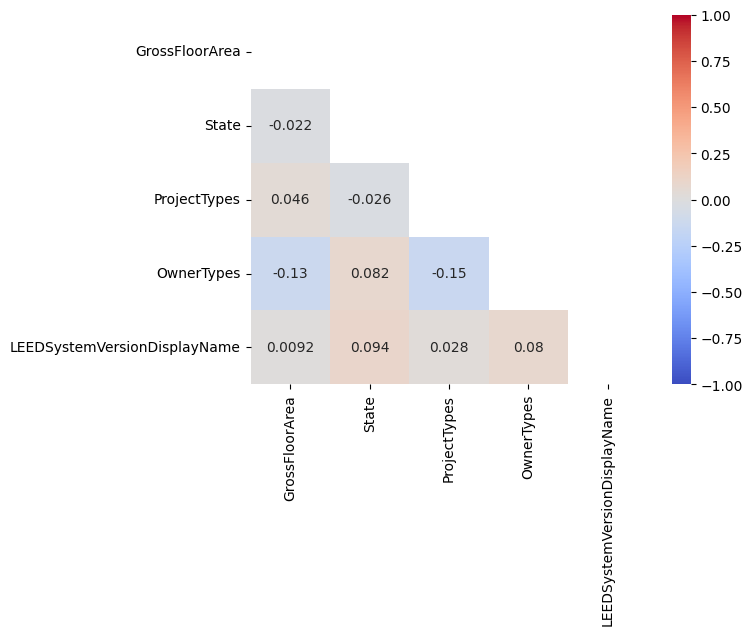

In [15]:
sns.heatmap(df2.corr(), annot=True, mask = np.triu(np.ones_like(df2.corr())), cmap="coolwarm", vmin=-1, vmax=1) 

# Split

In [16]:
X = df2.drop('CertLevel', axis=1)
y = df2['CertLevel']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Modelling

##1.KNN

In [18]:
knn = KNeighborsClassifier().fit(X_train, y_train)

#creating knn confusion matrix
y_predknn=knn.predict(X_test)
confusionknn = confusion_matrix(y_test,y_predknn)
actualknn = np.random.binomial(1,.9,size = 1000)
predictedknn = np.random.binomial(1,.9,size = 1000)


##2. RANDOM FOREST

In [19]:
rf = RandomForestClassifier().fit(X_train,y_train)

##3. LOGISTIC REGRESSION

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   Certified       0.34      0.84      0.49      4564
        Gold       0.48      0.16      0.24      4834
    Platinum       0.00      0.00      0.00      1554
      Silver       0.36      0.23      0.28      4906

    accuracy                           0.36     15858
   macro avg       0.30      0.31      0.25     15858
weighted avg       0.36      0.36      0.30     15858



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.CATBOOST

In [21]:
!pip install catboost
from catboost import CatBoostClassifier, Pool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.5 MB/s eta 0:00:00


In [23]:
cat_features2 = [col_name for col_name in X_train.columns if X_train[col_name].dtype == 'object']

In [24]:
model_cat = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42)

## Set the metric for evaluation
model_cat = CatBoostClassifier(eval_metric='Accuracy',
use_best_model=True,  random_seed=42)

model_cat.fit(X_train, y_train,cat_features=cat_features2,
eval_set=(X_test, y_test))


from catboost import cv
from sklearn.metrics import accuracy_score

print('the test accuracy is :{:.6f}'.format(accuracy_score(
y_test, model_cat.predict(X_test))))

Learning rate set to 0.11732
0:	learn: 0.4779284	test: 0.4783705	best: 0.4783705 (0)	total: 139ms	remaining: 2m 18s
1:	learn: 0.4876242	test: 0.4877664	best: 0.4877664 (1)	total: 229ms	remaining: 1m 54s
2:	learn: 0.4899259	test: 0.4902258	best: 0.4902258 (2)	total: 380ms	remaining: 2m 6s
3:	learn: 0.4873719	test: 0.4868836	best: 0.4902258 (2)	total: 477ms	remaining: 1m 58s
4:	learn: 0.4896737	test: 0.4917392	best: 0.4917392 (4)	total: 581ms	remaining: 1m 55s
5:	learn: 0.4852593	test: 0.4872619	best: 0.4917392 (4)	total: 675ms	remaining: 1m 51s
6:	learn: 0.4864260	test: 0.4889646	best: 0.4917392 (4)	total: 785ms	remaining: 1m 51s
7:	learn: 0.4849125	test: 0.4882078	best: 0.4917392 (4)	total: 920ms	remaining: 1m 54s
8:	learn: 0.4911871	test: 0.4927481	best: 0.4927481 (8)	total: 1.02s	remaining: 1m 52s
9:	learn: 0.4891376	test: 0.4904149	best: 0.4927481 (8)	total: 1.12s	remaining: 1m 51s
10:	learn: 0.4974933	test: 0.4969101	best: 0.4969101 (10)	total: 1.29s	remaining: 1m 56s
11:	learn: 0.

In [25]:
from sklearn import metrics
print(metrics.classification_report(y_test, model_cat.predict(X_test)))

              precision    recall  f1-score   support

   Certified       0.79      0.72      0.76      4564
        Gold       0.56      0.67      0.61      4834
    Platinum       0.71      0.43      0.54      1554
      Silver       0.57      0.58      0.58      4906

    accuracy                           0.63     15858
   macro avg       0.66      0.60      0.62     15858
weighted avg       0.65      0.63      0.63     15858



#Evaluation

In [26]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

y_pred_rf = rf.predict(X_test)

y_pred_knn = knn.predict(X_test)

y_pred_CLR = clf.predict(X_test)

# Calculate accuracy, F1 score, and sensitivity for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf, average='weighted')
sensitivity_rf = recall_score(y_test, y_pred_rf, average='weighted')

# Calculate accuracy, F1 score, and sensitivity for KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_score_knn = f1_score(y_test, y_pred_knn, average='weighted')
sensitivity_knn = recall_score(y_test, y_pred_knn, average='weighted')

# Calculate accuracy, F1 score, and sensitivity for logistic regression
accuracy_CLR = accuracy_score(y_test, y_pred_CLR)
f1_score_CLR = f1_score(y_test, y_pred_CLR, average='weighted')
sensitivity_CLR = recall_score(y_test, y_pred_CLR, average='weighted')

# Calculate accuracy, F1 score, and sensitivity for CATBOOST
accuracy_Catboost = accuracy_score(y_test, model_cat.predict(X_test))
f1_score_Catboost = f1_score(y_test, model_cat.predict(X_test), average='weighted')
sensitivity_Catboost = recall_score(y_test, model_cat.predict(X_test), average='weighted')


# Print the results
print("Random Forest: Accuracy = {:.2f}, F1 Score = {:.2f}, Sensitivity = {:.2f}".format(accuracy_rf, f1_score_rf, sensitivity_rf))
print("KNN: Accuracy = {:.2f}, F1 Score = {:.2f}, Sensitivity = {:.2f}".format(accuracy_knn, f1_score_knn, sensitivity_knn))
print("Logistic Regression: Accuracy = {:.2f}, F1 Score = {:.2f}, Sensitivity = {:.2f}".format(accuracy_CLR, f1_score_CLR, sensitivity_CLR))
print("CATBOOST: Accuracy = {:.2f}, F1 Score = {:.2f}, Sensitivity = {:.2f}".format(accuracy_Catboost, f1_score_Catboost, sensitivity_Catboost))

Random Forest: Accuracy = 0.65, F1 Score = 0.65, Sensitivity = 0.65
KNN: Accuracy = 0.57, F1 Score = 0.57, Sensitivity = 0.57
Logistic Regression: Accuracy = 0.36, F1 Score = 0.30, Sensitivity = 0.36
CATBOOST: Accuracy = 0.63, F1 Score = 0.63, Sensitivity = 0.63


In [27]:
from tabulate import tabulate

# Calculate scores for all models
models = {
    'Random Forest': {
        'Accuracy': accuracy_rf,
        'F1 Score': f1_score_rf,
        'Sensitivity': sensitivity_rf
    },
    'KNN': {
        'Accuracy': accuracy_knn,
        'F1 Score': f1_score_knn,
        'Sensitivity': sensitivity_knn
    },
    'Logistic Regression': {
        'Accuracy': accuracy_CLR,
        'F1 Score': f1_score_CLR,
        'Sensitivity': sensitivity_CLR
    },
    'CatBoost': {
        'Accuracy': accuracy_Catboost,
        'F1 Score': f1_score_Catboost,
        'Sensitivity': sensitivity_Catboost
    }
}

# Create table header and rows
table_header = ['Model', 'Accuracy', 'F1 Score', 'Sensitivity']
table_rows = []
for model_name, scores in models.items():
    table_rows.append([model_name, scores['Accuracy'], scores['F1 Score'], scores['Sensitivity']])

# Print the table
print(tabulate(table_rows, headers=table_header, tablefmt='fancy_grid'))

╒═════════════════════╤════════════╤════════════╤═══════════════╕
│ Model               │   Accuracy │   F1 Score │   Sensitivity │
╞═════════════════════╪════════════╪════════════╪═══════════════╡
│ Random Forest       │   0.648505 │   0.648889 │      0.648505 │
├─────────────────────┼────────────┼────────────┼───────────────┤
│ KNN                 │   0.573149 │   0.570246 │      0.573149 │
├─────────────────────┼────────────┼────────────┼───────────────┤
│ Logistic Regression │   0.360071 │   0.299547 │      0.360071 │
├─────────────────────┼────────────┼────────────┼───────────────┤
│ CatBoost            │   0.633876 │   0.634468 │      0.633876 │
╘═════════════════════╧════════════╧════════════╧═══════════════╛


# Save the best performing model

In [28]:
import pickle
filename = 'LEED_Model_new.sav'
pickle.dump(rf, open(filename, 'wb'))
for column in X.columns:
  print(column)

GrossFloorArea
State
ProjectTypes
OwnerTypes
LEEDSystemVersionDisplayName


In [29]:
# prediction testing
leed_model = pickle.load(open('LEED_Model_new.sav', 'rb'))
prediction = leed_model.predict(
        [[14535.0,	15,	10,	3,40	]])
print(prediction)

['Silver']


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
